**Book Crossing Dataset**<br>
We are buiding a book Recommender system using kNearest Neighbors Collaborative Filtering for User Based and Item based approches. We are also Creating Collaborative Filtering using RBM.

In [1]:
#Making necesarry imports
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
import os, sys
import re
import seaborn as sns

In [2]:
#Loading data
books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:27

In [3]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


### Data Exploration

In [4]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Droping the image url columns as they are not useful for our analysis

In [5]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [7]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null object
publisher            271358 non-null object
dtypes: object(5)
memory usage: 10.4+ MB


In [8]:
pd.set_option('display.max_colwidth', -1)

**yearOfPublication**

Converting the year of publications to int.

In [9]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

As it can be seen from below that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file
Also some of the entries are strings and same years have been entered as numbers in some places

In [10]:
books.loc[books.yearOfPublication == 'DK Publishing Inc',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
ISBN '0789466953'

In [11]:
books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

In [12]:
#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [13]:
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)",James Buckley,2000,DK Publishing Inc


Now Lets us check for the rows having 'Gallimard' as yearOfPublication

In [14]:
books.loc[books.yearOfPublication == 'Gallimard',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg


In [15]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

In [16]:
books.loc[books.ISBN == '2070426769',:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard


Correcting the dtypes of yearOfPublication

In [17]:
books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [18]:
print(sorted(books['yearOfPublication'].unique()))

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


However, the value 0 is invalid and as this dataset was published in 2004, I have assumed the the years after 2006 to be 
invalid keeping some margin in case dataset was updated thereafer
setting invalid years as NaN

In [19]:
books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN

Replacing NaNs with mean value of yearOfPublication

In [20]:
books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

In [21]:
books.yearOfPublication.isnull().sum()

0

In [22]:
books.yearOfPublication = books.yearOfPublication.astype(np.int32)

**publisher**

In [23]:
books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [24]:
books.loc[(books.bookTitle == 'Tyrant Moon'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


In [25]:
books.loc[(books.bookTitle == 'Finders Keepers'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
10799,082177364X,Finders Keepers,Fern Michaels,2002,Zebra Books
42019,0070465037,Finders Keepers,Barbara Nickolae,1989,McGraw-Hill Companies
58264,0688118461,Finders Keepers,Emily Rodda,1993,Harpercollins Juvenile Books
66678,1575663236,Finders Keepers,Fern Michaels,1998,Kensington Publishing Corporation
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN
134309,0156309505,Finders Keepers,Will,1989,Voyager Books
173473,0973146907,Finders Keepers,Sean M. Costello,2002,Red Tower Publications
195885,0061083909,Finders Keepers,Sharon Sala,2003,HarperTorch
211874,0373261160,Finders Keepers,Elizabeth Travis,1993,Worldwide Library


In [26]:
books.loc[(books.bookAuthor == 'Elaine Corvidae'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
126762,1931696934,Winter's Orphans,Elaine Corvidae,2001,Novelbooks
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129001,0759901880,Wolfkin,Elaine Corvidae,2001,Hard Shell Word Factory


In [27]:
books.loc[(books.bookAuthor == 'Linnea Sinclair'),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Since there is nothing in common to infer publisher for NaNs, replacing these with 'other

In [28]:
books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

**Users**

In [29]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [30]:
users.dtypes

userID      int64  
Location    object 
Age         float64
dtype: object

**userID**

In [31]:
users.userID.values

array([     1,      2,      3, ..., 278856, 278857, 278858])

**Age**

In [32]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Age column has some invalid entries like nan, 0 and very high values like 100 and above

In [33]:
users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan

In my view values below 5 and above 90 do not make much sense for our book rating case...hence replacing these by NaNs

In [34]:
users.Age = users.Age.fillna(users.Age.mean())

Replacing NaNs with mean

In [35]:
users.Age = users.Age.astype(np.int32)

In [37]:
print(sorted(users.Age.unique()))

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


**Ratings Dataset**

In [38]:
ratings.shape

(1149780, 3)

In [39]:
#ratings dataset will have n_users*n_books entries if every user rated every item, this shows that the dataset is very sparse
n_users = users.shape[0]
n_books = books.shape[0]
print(n_users * n_books)

75670906880


In [40]:
#checking first few rows...
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [41]:
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [42]:
#ratings dataset should have books only which exist in our books dataset, unless new books are added to books dataset
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

In [43]:
print(ratings.shape)
print(ratings_new.shape)
#it can be seen that many rows having book ISBN not part of books dataset got dropped off

(1149780, 3)
(1031136, 3)


In [44]:
#ratings dataset should have ratings from users which exist in users dataset, unless new users are added to users dataset
ratings = ratings[ratings.userID.isin(users.userID)]

In [45]:
print(ratings.shape)
print(ratings_new.shape)
#no new users added, hence we will go with above dataset ratings_new (1031136, 3)

(1149780, 3)
(1031136, 3)


In [46]:
print("number of users: " + str(n_users))
print("number of books: " + str(n_books))

number of users: 278858
number of books: 271360


In [47]:
#Sparsity of dataset in %
sparsity=1.0-len(ratings_new)/float(n_users*n_books)
print('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 99.99863734155898 %


In [48]:
#As quoted in the description of the dataset -
#BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 
#higher values denoting higher appreciation, or implicit, expressed by 0
ratings.bookRating.unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

In [49]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]

In [50]:
#checking shapes
print(ratings_new.shape)
print(ratings_explicit.shape)
print(ratings_implicit.shape)

(1031136, 3)
(383842, 3)
(647294, 3)


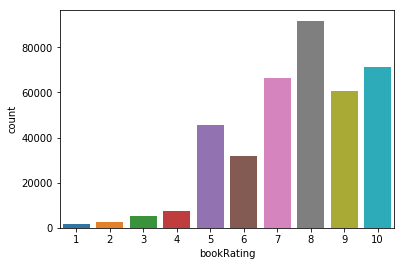

In [51]:
#plotting count of bookRating
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()
#It can be seen that higher ratings are more common amongst users and rating 8 has been rated highest number of times

**Simple Popularity Based Recommendation System**

In [52]:
#At this point , a simple popularity based recommendation system can be built based on count of user ratings for different books
ratings_count = pd.DataFrame(ratings_explicit.groupby(['ISBN'])['bookRating'].sum())
top10 = ratings_count.sort_values('bookRating', ascending = False).head(10)
print("Following books are recommended")
top10.merge(books, left_index = True, right_on = 'ISBN')

#Given below are top 10 recommendations based on popularity. It is evident that books authored by J.K. Rowling are most popular

Following books are recommended


,bookRating,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
408,5787,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown"
748,4108,0385504209,The Da Vinci Code,Dan Brown,2003,Doubleday
522,3134,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA
2143,2798,059035342X,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),J. K. Rowling,1999,Arthur A. Levine Books
356,2595,0142001740,The Secret Life of Bees,Sue Monk Kidd,2003,Penguin Books
26,2551,0971880107,Wild Animus,Rich Shapero,2004,Too Far
1105,2524,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997,Perennial
706,2402,0446672211,Where the Heart Is (Oprah's Book Club (Paperback)),Billie Letts,1998,Warner Books
231,2219,0452282152,Girl with a Pearl Earring,Tracy Chevalier,2001,Plume Books
118,2179,0671027360,Angels &amp; Demons,Dan Brown,2001,Pocket Star


In [53]:
#Similarly segregating users who have given explicit ratings from 1-10 and those whose implicit behavior was tracked
users_exp_ratings = users[users.userID.isin(ratings_explicit.userID)]
users_imp_ratings = users[users.userID.isin(ratings_implicit.userID)]

In [54]:
#checking shapes
print(users.shape)
print(users_exp_ratings.shape)
print(users_imp_ratings.shape)

(278858, 3)
(68091, 3)
(52451, 3)


**Collaborative Filtering Based Recommendation Systems**

To cope up with computing power I have and to reduce the dataset size, I am considering users who have rated atleast 100 books and books which have atleast 100 ratings

In [55]:
counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 100].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 100].index)]

Generating ratings matrix from explicit ratings table

In [56]:
ratings_matrix = ratings_explicit.pivot(index='userID', columns='ISBN', values='bookRating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()
#Notice that most of the values are NaN (undefined) implying absence of ratings

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
n_users = ratings_matrix.shape[0] #considering only those users who gave explicit ratings
n_books = ratings_matrix.shape[1]
print(n_users, n_books)

449 66574


In [58]:
#since NaNs cannot be handled by training algorithms, replacing these by 0, which indicates absence of ratings
#setting data type
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)

In [59]:
#checking first few rows
ratings_matrix.head(5)

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
#rechecking the sparsity
sparsity=1.0-len(ratings_explicit)/float(users_exp_ratings.shape[0]*n_books)
print('The sparsity level of Book Crossing dataset is ' +  str(sparsity*100) + ' %')

The sparsity level of Book Crossing dataset is 99.99772184106935 %


**Training our recommendation system**

**User-based Recommendation System**

In [65]:
def findksimilarusers(user_id, ratings, metric = 'cosine', k=10):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
            
    return similarities,indices

This function finds k similar users given the user_id and ratings matrix.
These similarities are same as obtained via using pairwise_distances

In [68]:
def predict_userbased(user_id, item_id, ratings, metric = metric, k=10,wt=1):
    prediction=0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k,wt) #similar users based on cosine similarity
    mean_rating = ratings.iloc[user_loc,:].mean() #to adjust for zero based indexing
    sum_wt = np.sum(similarities)-1
    product=1
    wtd_sum = 0 
    
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == user_loc:
            continue;
        else: 
            ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
            product = ratings_diff * (similarities[i])
            wtd_sum = wtd_sum + product
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10
    
    prediction = int(round(mean_rating + (wtd_sum/sum_wt)))
#     print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))

    return prediction

This function predicts rating for specified user-item combination based on user-based approach

In [69]:
predict_userbased(11676,'0001056107',ratings_matrix);

**Item-based Recommendation Systems**

In [70]:
#This function finds k similar items given the item_id and ratings matrix

def findksimilaritems(item_id, ratings, metric='cosine', k=k):
    similarities=[]
    indices=[]
    ratings=ratings.T
    loc = ratings.index.get_loc(item_id)
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute')
    model_knn.fit(ratings)
    
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()

    return similarities,indices

In [71]:
similarities,indices=findksimilaritems('0001056107',ratings_matrix)

In [72]:
#This function predicts the rating for specified user-item combination based on item-based approach
def predict_itembased(user_id, item_id, ratings, metric = metric, k=k):
    prediction= wtd_sum =0
    user_loc = ratings.index.get_loc(user_id)
    item_loc = ratings.columns.get_loc(item_id)
    similarities, indices=findksimilaritems(item_id, ratings) #similar users based on correlation coefficients
    sum_wt = np.sum(similarities)-1
    product=1
    for i in range(0, len(indices.flatten())):
        if indices.flatten()[i] == item_loc:
            continue;
        else:
            product = ratings.iloc[user_loc,indices.flatten()[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    prediction = int(round(wtd_sum/sum_wt))
    
    #in case of very sparse datasets, using correlation metric for collaborative based approach may give negative ratings
    #which are handled here as below //code has been validated without the code snippet below, below snippet is to avoid negative
    #predictions which might arise in case of very sparse datasets when using correlation metric
    if prediction <= 0:
        prediction = 1   
    elif prediction >10:
        prediction = 10

#     print('\nPredicted rating for user {0} -> item {1}: {2}'.format(user_id,item_id,prediction))      
    
    return prediction

In [73]:
prediction = predict_itembased(11676,'0001056107',ratings_matrix)

In [74]:
def recommend_itembased(user_id, ratings, metric='cosine'):
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else: 
        prediction = []
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] !=0): 
                prediction.append(predict_itembased(user_id, str(ratings.columns[i]) ,ratings, metric))
            else:                    
                prediction.append(-1) 
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        for i in range(len(recommended)):
            print ("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]].encode('utf-8')))

In [75]:
recommend_itembased(4385,ratings_matrix,metric='cosine')

1. b'My Wicked Wicked Ways'
2. b'Fair Peril'
3. b'Wolfpointe'
4. b'A Nest of Ninnies'
5. b'A Bitter Legacy'
6. b'A Hymn Before Battle'
7. b'Thomas the Rhymer'
8. b'Gatherer of Clouds (Initiate Brother Duology)'
9. b'Wege zum Ruhm: 13 Hilfestellungen f\xc3\x83\xc2\xbcr junge K\xc3\x83\xc2\xbcnstler und 1 Warnung'
10. b"Love In Bloom's"


In [76]:
def recommend_userbased(user_id, ratings, metric='cosine'):
    if (user_id not in ratings.index.values) or type(user_id) is not int:
        print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
    else:    
        prediction = []
        for i in range(ratings.shape[1]):
            if (ratings[str(ratings.columns[i])][user_id] !=0): 
                prediction.append(predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric))
            else:                    
                prediction.append(-1) 
        prediction = pd.Series(prediction)
        prediction = prediction.sort_values(ascending=False)
        recommended = prediction[:10]
        for i in range(len(recommended)):
            print ("{0}. {1}".format(i+1,books.bookTitle[recommended.index[i]].encode('utf-8')))

In [77]:
recommend_userbased(4385,ratings_matrix,metric='cosine')

1. b'The Gift'
2. b"A Close Run Thing : A Novel of Wellington's Army of 1815"
3. b'Mazurka for Two Dead Men'
4. b'The Romantic: A Novel'
5. b'And Never Let Her Go : Thomas Capano: The Deadly Seducer'
6. b'Outerbridge Reach'
7. b"The Titanic Conspiracy: Cover-Ups and Mysteries of the World's Most Famous Sea Disaster"
8. b'WHO NEEDS GOD'
9. b'Chop Wood, Carry Water: A Guide to Finding Spiritual Fulfillment in Everyday Life'
10. b'Under the Volcano'


**RBM Implementation**

In [78]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [79]:
normalized_usr_rating = ratings_matrix.fillna(0)/10.0
normalized_usr_rating.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
matrix = normalized_usr_rating.values
matrix[0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [81]:
hiddenunits = 20
visibleunits = len(ratings_matrix.columns)
hb = tf.placeholder("float",[hiddenunits])
vb = tf.placeholder("float",[visibleunits])
W = tf.placeholder("float",[visibleunits,hiddenunits])

In [82]:
v0 = tf.placeholder("float",[None,visibleunits])
_h0 = tf.nn.sigmoid(tf.matmul(v0,W)+hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [83]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [84]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [85]:
#Current weight
cur_w = np.zeros([visibleunits, hiddenunits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleunits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenunits], np.float32)
#Previous weight
prv_w = np.zeros([visibleunits, hiddenunits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleunits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenunits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.199214
0.11764492
0.08311651
0.06443759
0.05280197
0.04479922
0.039032273
0.03475944
0.031345226
0.028597921
0.026345327
0.024421686
0.022858303
0.021532856
0.020376788
0.019279858
0.01840173
0.017590582
0.016872969
0.016225977
0.015601996
0.015126114
0.014655449
0.014165619
0.013760474


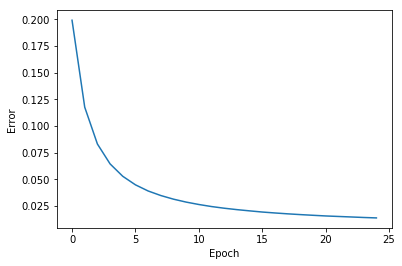

In [86]:
epochs = 25
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(matrix), batchsize), range(batchsize, len(matrix), batchsize)):
        batch = matrix[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: matrix, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [87]:
mock_user_id = 4385

In [88]:
matrix.shape

(449, 66574)

In [89]:
ratings_matrix.shape

(449, 66574)

In [90]:
ratings_matrix.index.get_loc(4385)

4

In [91]:
inputUser = matrix[ratings_matrix.index.get_loc(4385)-1].reshape(1, -1)
inputUser[0:5]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [92]:
inputUser.shape

(1, 66574)

In [93]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec.shape)

(1, 66574)


In [94]:
rec.shape

(1, 66574)

In [95]:
rec[0][0:576]

array([0.01200917, 0.01148682, 0.01035371, 0.01040508, 0.01148681,
       0.00995177, 0.01325545, 0.01082512, 0.01126193, 0.01098692,
       0.01286876, 0.01177419, 0.01286874, 0.01165839, 0.01050855,
       0.01087878, 0.0118911 , 0.01143018, 0.01212843, 0.01293242,
       0.01177419, 0.01126193, 0.01177419, 0.01148685, 0.01200917,
       0.01015075, 0.01098692, 0.01071854, 0.01050853, 0.01171617,
       0.01030261, 0.01171616, 0.01212842, 0.01137384, 0.01098691,
       0.01061305, 0.01137383, 0.01154373, 0.01109612, 0.01050855,
       0.01109612, 0.01082511, 0.01160095, 0.01035372, 0.00970848,
       0.01171614, 0.01066567, 0.01243163, 0.01050855, 0.01115111,
       0.01165838, 0.01165838, 0.01005078, 0.01143019, 0.01189111,
       0.01087877, 0.01115113, 0.01066567, 0.0118911 , 0.01104138,
       0.01171615, 0.01087878, 0.01286877, 0.01120637, 0.01154372,
       0.01045668, 0.01154372, 0.0116584 , 0.01061305, 0.01189111,
       0.00970848, 0.01020116, 0.01212842, 0.01077171, 0.01015

In [96]:
books.shape

(271360, 5)

In [97]:
books[books['ISBN'].isin(ratings_matrix.columns)]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
6,0425176428,What If?: The World's Foremost Military Historians Imagine What Might Have Been,Robert Cowley,2000,Berkley Publishing Group
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks
18,0440234743,The Testament,John Grisham,1999,Dell
19,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume
20,0609804618,Our Dumb Century: The Onion Presents 100 Years of Headlines from America's Finest News Source,The Onion,1999,Three Rivers Press
21,1841721522,New Vegetarian: Bold and Beautiful Recipes for Every Occasion,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
26,0971880107,Wild Animus,Rich Shapero,2004,Too Far


In [98]:
scored_movies_df_mock = books[books['ISBN'].isin(ratings_matrix.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0][0:len(scored_movies_df_mock)])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,RecommendationScore
21100,0373194870,"Hunter'S Vow (Silhouette Romance, No 1487)",Susan Meier,2000,Silhouette,0.135287
43632,0743250508,"Fire Flight : A Novel (Nance, John J)",John Nance,2003,Simon &amp; Schuster,0.096651
56701,0553563327,Thief of Hearts,TERESA MEDEIROS,1994,Bantam,0.091955
24490,0553268074,Beet Queen,Louise Erdrich,1987,Bantam Doubleday Dell,0.088669
61338,0373226152,"Conception Cover-Up (Top Secret Babies) (Harlequin Intrigue, No 615)",Karen Barrett,2001,Harlequin,0.088669
56146,1551668955,Too Hot to Handle,Elizabeth Lowell,2002,Mira,0.086274
100527,8420482536,Amantes y Enemigos: Cuentos de Parejas,Rosa Montero,1998,Schoenhof Foreign Books Inc,0.079805
56305,0061010235,Veritas,William Lashner,1997,Regan Books,0.076562
17227,0373031424,"Lovespell (Harlequin Romance, No 3142)",Jennifer Taylor,1991,Harlequin,0.075508
56283,1888451416,Southland,Nina Revoyr,2003,Akashic Books,0.072091


In [99]:
scored_movies_df_mock.columns

Index(['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'RecommendationScore'],
      dtype='object')

In [100]:
books_df_mock = ratings[ratings['userID'] == mock_user_id]
books_df_mock.head() 

,userID,ISBN,bookRating
21688,4385,0061042331,0
21689,4385,0061083402,10
21690,4385,0061083577,0
21691,4385,0061093343,9
21692,4385,0061096156,10


In [101]:
merged_df_mock = scored_movies_df_mock.merge(books_df_mock, on='ISBN', how='outer')

In [102]:
merged_df_mock=merged_df_mock[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'RecommendationScore']]

In [103]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(10)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,RecommendationScore
10345,0373194870,"Hunter'S Vow (Silhouette Romance, No 1487)",Susan Meier,2000.0,Silhouette,0.135287
19630,0743250508,"Fire Flight : A Novel (Nance, John J)",John Nance,2003.0,Simon &amp; Schuster,0.096651
23462,0553563327,Thief of Hearts,TERESA MEDEIROS,1994.0,Bantam,0.091955
11783,0553268074,Beet Queen,Louise Erdrich,1987.0,Bantam Doubleday Dell,0.088669
25396,0373226152,"Conception Cover-Up (Top Secret Babies) (Harlequin Intrigue, No 615)",Karen Barrett,2001.0,Harlequin,0.088669
23307,1551668955,Too Hot to Handle,Elizabeth Lowell,2002.0,Mira,0.086274
35086,8420482536,Amantes y Enemigos: Cuentos de Parejas,Rosa Montero,1998.0,Schoenhof Foreign Books Inc,0.079805
23356,0061010235,Veritas,William Lashner,1997.0,Regan Books,0.076562
8160,0373031424,"Lovespell (Harlequin Romance, No 3142)",Jennifer Taylor,1991.0,Harlequin,0.075508
23350,1888451416,Southland,Nina Revoyr,2003.0,Akashic Books,0.072091


In [105]:
class HybridAlgorithm(AlgoBase):

    def __init__(self, algorithms, weights, sim_options={}):
        AlgoBase.__init__(self)
        self.algorithms = algorithms
        self.weights = weights

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        
        for algorithm in self.algorithms:
            algorithm.fit(trainset)
                
        return self

    def estimate(self, u, i):
        
        sumScores = 0
        sumWeights = 0
        
        for idx in range(len(self.algorithms)):
            sumScores += self.algorithms[idx].estimate(u, i) * self.weights[idx]
            sumWeights += self.weights[idx]
            
        return sumScores / sumWeights

In [155]:
class RBM:
    def __init__(self,ratings_matrix,hiddenunits=20,alpha=1):
        self.hiddenunits = hiddenunits
        self.visibleunits = len(ratings_matrix.columns)
        self.alpha = alpha
    def _create_variables(self):        
        self.hb = tf.placeholder("float",[self.hiddenunits])
        self.vb = tf.placeholder("float",[self.visibleunits])
        self.W = tf.placeholder("float",[self.visibleunits,self.hiddenunits])
        self.v0 = tf.placeholder("float",[None,self.visibleunits])
    def _create_graph(self):
        self._h0 = tf.nn.sigmoid(tf.matmul(self.v0,self.W)+self.hb)
        self.h0 = tf.nn.relu(tf.sign(self._h0 - tf.random_uniform(tf.shape(self._h0))))
        #Phase 2: Reconstruction
        self._v1 = tf.nn.sigmoid(tf.matmul(self.h0, tf.transpose(self.W)) + self.vb) 
        self.v1 = tf.nn.relu(tf.sign(self._v1 - tf.random_uniform(tf.shape(self._v1))))
        self.h1 = tf.nn.sigmoid(tf.matmul(self.v1, self.W) + self.hb)
        #Create the gradients
        self.w_pos_grad = tf.matmul(tf.transpose(self.v0), self.h0)
        self.w_neg_grad = tf.matmul(tf.transpose(self.v1), self.h1)
        
        #Calculate the Contrastive Divergence to maximize
        self.CD = (self.w_pos_grad - self.w_neg_grad) / tf.to_float(tf.shape(self.v0)[0])
        #Create methods to update the weights and biases
        self.update_w = self.W + self.alpha * self.CD
        self.update_vb = self.vb + self.alpha * tf.reduce_mean(self.v0 - self.v1, 0)
        self.update_hb = self.hb + self.alpha * tf.reduce_mean(self.h0 - self.h1, 0)
        self.err = self.v0 - self.v1
        self.err_sum = tf.reduce_mean(self.err * self.err)
        self.cur_w = np.zeros([self.visibleunits, self.hiddenunits], np.float32)
        self.cur_vb = np.zeros([self.visibleunits], np.float32)
        self.cur_hb = np.zeros([self.hiddenunits], np.float32)
        self.prv_w = np.zeros([self.visibleunits, self.hiddenunits], np.float32)
        self.prv_vb = np.zeros([self.visibleunits], np.float32)
        self.prv_hb = np.zeros([self.hiddenunits], np.float32)
        
    def train(self,epochs=25,batchsize=100):
        errors = []
        self._create_variables()
        self._create_graph()
        sess = tf.Session()
        sess.run(tf.global_variables_initializer())
        for i in range(epochs):
            for start, end in zip( range(0, len(matrix), batchsize), range(batchsize, len(matrix), batchsize)):
                self.batch = matrix[start:end]
                self.cur_w = sess.run(self.update_w, feed_dict={self.v0: self.batch, self.W: self.prv_w, self.vb: self.prv_vb, self.hb: self.prv_hb})
                self.cur_vb = sess.run(self.update_vb, feed_dict={self.v0: self.batch, self.W: self.prv_w, self.vb: self.prv_vb, self.hb: self.prv_hb})
                self.cur_nb = sess.run(self.update_hb, feed_dict={self.v0: self.batch, self.W: self.prv_w, self.vb: self.prv_vb, self.hb: self.prv_hb})
                self.prv_w = self.cur_w
                self.prv_vb = self.cur_vb
                self.prv_hb = self.cur_hb
            errors.append(sess.run(self.err_sum, feed_dict={self.v0: matrix, self.W: self.cur_w, self.vb: self.cur_vb, self.hb: self.cur_hb}))
        plt.plot(errors)
        plt.ylabel('Error')
        plt.xlabel('Epoch')
        plt.show()
    def recommend(self,userID,wt):
        inputUser = matrix[ratings_matrix.index.get_loc(userID)-1].reshape(1, -1)
        self.hh0 = tf.nn.sigmoid(tf.matmul(self.v0, self.W) + self.hb)
        self.vv1 = tf.nn.sigmoid(tf.matmul(self.hh0, tf.transpose(self.W)) + self.vb)
        self.feed = sess.run(self.hh0, feed_dict={ self.v0: inputUser, self.W: self.prv_w, self.hb: self.prv_hb})
        self.rec = sess.run(self.vv1, feed_dict={ self.hh0: self.feed, self.W: self.prv_w, self.vb: self.prv_vb})
        scored_movies_df_mock = books[books['ISBN'].isin(ratings_matrix.columns)]
        scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0][0:len(scored_movies_df_mock)]*wt)
        scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)
        books_df_mock = ratings[ratings['userID'] == userID]
        merged_df_mock = scored_movies_df_mock.merge(books_df_mock, on='ISBN', how='outer')
        merged_df_mock=merged_df_mock[['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher',
       'RecommendationScore']]
        return merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(10)
        

In [156]:
rbm = RBM(ratings_matrix)

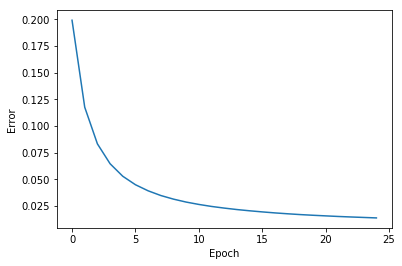

In [157]:
rbm.train(epochs=25,batchsize=100)

In [159]:
rbm.recommend(4385,0.6)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,RecommendationScore
10345,0373194870,"Hunter'S Vow (Silhouette Romance, No 1487)",Susan Meier,2000.0,Silhouette,0.081172
19630,0743250508,"Fire Flight : A Novel (Nance, John J)",John Nance,2003.0,Simon &amp; Schuster,0.057991
23462,0553563327,Thief of Hearts,TERESA MEDEIROS,1994.0,Bantam,0.055173
11783,0553268074,Beet Queen,Louise Erdrich,1987.0,Bantam Doubleday Dell,0.053201
25396,0373226152,"Conception Cover-Up (Top Secret Babies) (Harlequin Intrigue, No 615)",Karen Barrett,2001.0,Harlequin,0.053201
23307,1551668955,Too Hot to Handle,Elizabeth Lowell,2002.0,Mira,0.051765
35086,8420482536,Amantes y Enemigos: Cuentos de Parejas,Rosa Montero,1998.0,Schoenhof Foreign Books Inc,0.047883
23356,0061010235,Veritas,William Lashner,1997.0,Regan Books,0.045937
8160,0373031424,"Lovespell (Harlequin Romance, No 3142)",Jennifer Taylor,1991.0,Harlequin,0.045305
23350,1888451416,Southland,Nina Revoyr,2003.0,Akashic Books,0.043255


In [132]:
rbm.recommend(4385)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,RecommendationScore
10345,0373194870,"Hunter'S Vow (Silhouette Romance, No 1487)",Susan Meier,2000.0,Silhouette,0.135287
19630,0743250508,"Fire Flight : A Novel (Nance, John J)",John Nance,2003.0,Simon &amp; Schuster,0.096651
23462,0553563327,Thief of Hearts,TERESA MEDEIROS,1994.0,Bantam,0.091955
11783,0553268074,Beet Queen,Louise Erdrich,1987.0,Bantam Doubleday Dell,0.088669
25396,0373226152,"Conception Cover-Up (Top Secret Babies) (Harlequin Intrigue, No 615)",Karen Barrett,2001.0,Harlequin,0.088669
23307,1551668955,Too Hot to Handle,Elizabeth Lowell,2002.0,Mira,0.086274
35086,8420482536,Amantes y Enemigos: Cuentos de Parejas,Rosa Montero,1998.0,Schoenhof Foreign Books Inc,0.079805
23356,0061010235,Veritas,William Lashner,1997.0,Regan Books,0.076562
8160,0373031424,"Lovespell (Harlequin Romance, No 3142)",Jennifer Taylor,1991.0,Harlequin,0.075508
23350,1888451416,Southland,Nina Revoyr,2003.0,Akashic Books,0.072091


In [188]:
class knnCF:
    def findksimilarusers_wt(self,user_id, ratings, metric = 'cosine', k=10,wt=1):
        similarities=[]
        indices=[]
        model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
        model_knn.fit(ratings)
        loc = ratings.index.get_loc(user_id)
        distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
        similarities = 1-distances.flatten()
        return similarities,indices
    def predict_userbased(self,user_id, item_id, ratings, metric = metric, k=10,wt=1):
        prediction=0
        user_loc = ratings.index.get_loc(user_id)
        item_loc = ratings.columns.get_loc(item_id)
        similarities, indices=self.findksimilarusers_wt(user_id, ratings,metric, k,wt)
        mean_rating = ratings.iloc[user_loc,:].mean()
        sum_wt = np.sum(similarities)-1
        product=1
        wtd_sum = 0 

        for i in range(0, len(indices.flatten())):
            if indices.flatten()[i] == user_loc:
                continue;
            else: 
                ratings_diff = ratings.iloc[indices.flatten()[i],item_loc]-np.mean(ratings.iloc[indices.flatten()[i],:])
                product = ratings_diff * (similarities[i])
                wtd_sum = wtd_sum + product
        if prediction <= 0:
            prediction = 1   
        elif prediction >10:
            prediction = 10

        prediction = int(round(mean_rating + (wtd_sum/sum_wt)))

        return prediction
    def recommend_userbased(self,user_id, ratings, metric='cosine',wt=1):
        if (user_id not in ratings.index.values) or type(user_id) is not int:
            print("User id should be a valid integer from this list :\n\n {} ".format(re.sub('[\[\]]', '', np.array_str(ratings_matrix.index.values))))
        else:    
            prediction = []
            for i in range(ratings.shape[1]):
                if (ratings[str(ratings.columns[i])][user_id] !=0): 
                    prediction.append(self.predict_userbased(user_id, str(ratings.columns[i]) ,ratings, metric,wt))
                else:                    
                    prediction.append(-1) 
            prediction = pd.Series(prediction)
            prediction = prediction.sort_values(ascending=False)
            recommended = prediction[:10]
            merged_books = books.loc[recommended.index]
            merged_books['RecommendationScore'] = recommended
            return merged_books
                

In [189]:
knn = knnCF()

In [ ]:
knn.recommend_userbased(4385,ratings_matrix,wt=1)

In [176]:
knn.recommend_userbased(4385,ratings_matrix,wt=4)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
26089,038531292X,The Gift,Danielle Steel,1994,Delacorte Press
57688,0553380435,A Close Run Thing : A Novel of Wellington's Army of 1815,ALLAN MALLINSON,2000,Bantam
13339,0525484272,Roger Caras' Treasury of Great Cat Stories,Roger A. Caras,1988,Dutton Books
25616,0811212777,Mazurka for Two Dead Men,Camilo Jose Cela,1994,New Directions Publishing Corporation
13483,0874772095,"Chop Wood, Carry Water: A Guide to Finding Spiritual Fulfillment in Everyday Life",Rick Fields,1984,Jeremy P. Tarcher
14764,1559723475,The Titanic Conspiracy: Cover-Ups and Mysteries of the World's Most Famous Sea Disaster,Robin Gardiner,1996,Carol Publishing Corporation
14223,0805071903,The Romantic: A Novel,Barbara Gowdy,2003,Metropolitan Books
57720,0395938945,Outerbridge Reach,Robert Stone,1998,Houghton Mifflin Co
25535,0452255953,Under the Volcano,Malcolm Lowry,1992,Penguin USA
33945,0684810484,And Never Let Her Go : Thomas Capano: The Deadly Seducer,Ann Rule,1999,Simon &amp; Schuster


In [177]:
books.loc[25616],prediction

(ISBN                 0811212777                           
 bookTitle            Mazurka for Two Dead Men             
 bookAuthor           Camilo Jose Cela                     
 yearOfPublication    1994                                 
 publisher            New Directions Publishing Corporation
 Name: 25616, dtype: object, 1)

In [178]:
prediction

1